# @**CodeClause Project : Speech Emotion Recognition**

## **Summary To Explain Project (Keypoints)**

1. Importing the required libraries
2. Importing datasets & Labels
3. Plotting the audio file's waveform and its spectrogram
4. Spectogram
5. Trim the Audio
6. Waveform of the noise in the audio
7. Feature Extraction
8. RMSE
9. Spectral Bandwidth ( Incomplete)
10. Delta MFCCS
11. Delta Delta MFCCs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Importing the required libraries

In [2]:
import os
import random
import sys

import warnings
warnings.filterwarnings('ignore')

import glob
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

import sklearn
import soundfile as sf
import sklearn.preprocessing

### 2. Importing datasets & Labels

In [3]:
# Data Directory
# Please edit according to your directory change.
Ravdess_paths= np.array(("/content/drive/MyDrive/Speech Emotion Recognation/audio_speech_actors_01-24/","/content/drive/MyDrive/Speech Emotion Recognation/audio_speech_actors_01-24"))
# Ravdess_paths = r"/content/drive/MyDrive/Speech Emotion Recognation/audio_speech_actors_01-24"
# print(Ravdess_paths)
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

[b'Actor_01', b'Actor_02', b'Actor_03', b'Actor_04', b'Actor_05', b'Actor_06', b'Actor_07', b'Actor_08', b'Actor_09', b'Actor_10', b'Actor_11', b'Actor_12', b'Actor_13', b'Actor_14', b'Actor_15', b'Actor_16', b'Actor_17', b'Actor_18', b'Actor_19', b'Actor_20', b'Actor_21', b'Actor_22', b'Actor_23', b'Actor_24']


In [4]:
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0

for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    
    for i in dir_list:
        i = i.decode('utf-8')  # Convert bytes to str if needed
        file_list = os.listdir('/content/drive/MyDrive/Speech Emotion Recognation/audio_speech_actors_01-24/' + i)
        
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor) % 2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1


In [5]:
print (len(ravdess_db))

2880


In [6]:
ravdess_db.sort_values(by='path',inplace=True)
ravdess_db.index =  range(len(ravdess_db.index))
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/drive/MyDrive/Speech Emotion Recognat...,Ravdess,1,male,1,neutral
1,/content/drive/MyDrive/Speech Emotion Recognat...,Ravdess,1,male,1,neutral
2,/content/drive/MyDrive/Speech Emotion Recognat...,Ravdess,1,male,1,neutral
3,/content/drive/MyDrive/Speech Emotion Recognat...,Ravdess,1,male,1,neutral
4,/content/drive/MyDrive/Speech Emotion Recognat...,Ravdess,1,male,2,calm


### 3. Plotting the audio file's waveform and its spectrogram

In [7]:
# Load the audio with sampling rate(sr) = 44100 ( which is the standard sr for high quality audio)
sampling_rate = 44100

In [8]:
filename = ravdess_db.path[2]
print (filename)

/content/drive/MyDrive/Speech Emotion Recognation/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav


In [9]:
samples, sample_rate = sf.read(filename)




In [10]:
ipd.Audio(samples,rate=sample_rate)

### 4. Spectogram 

In [11]:
def log_specgram(audio, sample_rate, window_size=20,step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


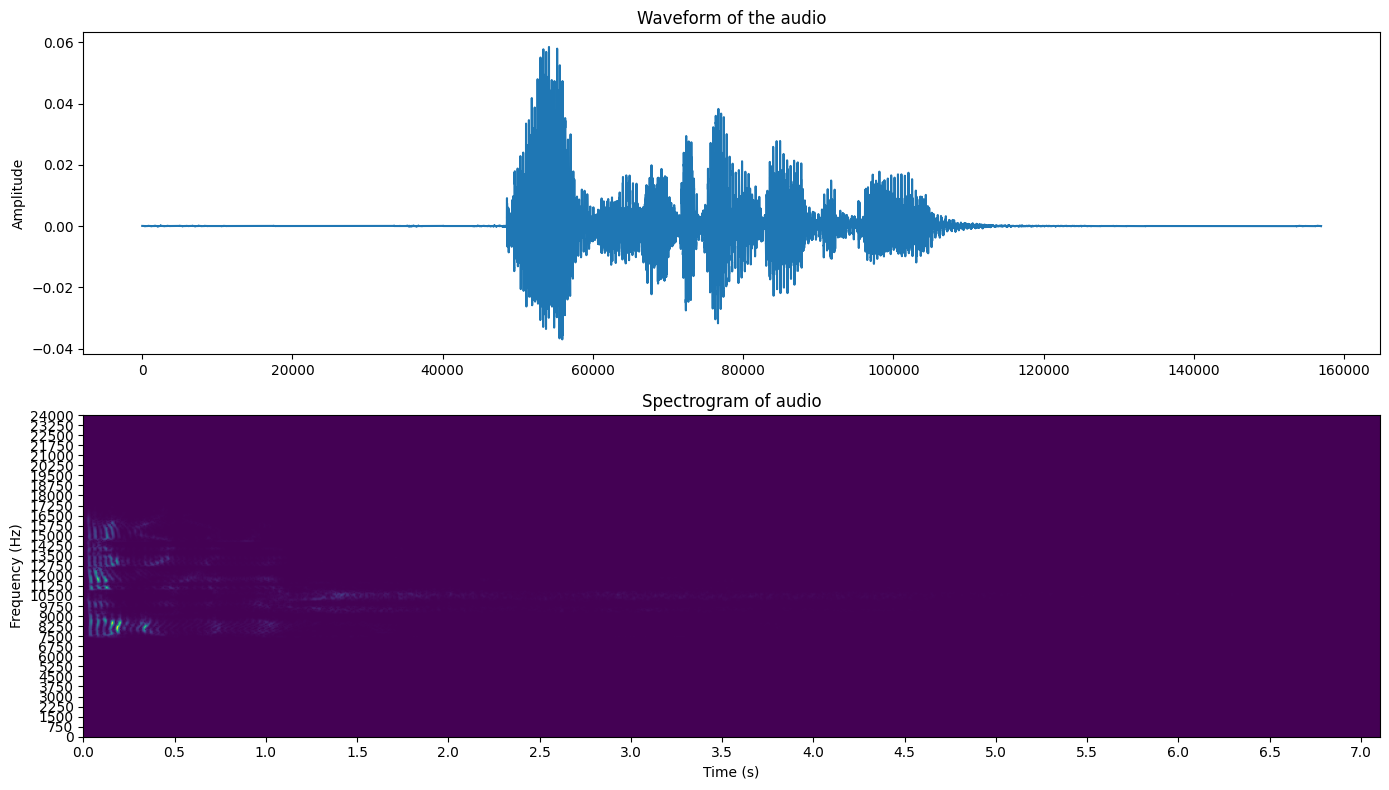

In [12]:
# Compute spectrogram
spectrogram = np.abs(librosa.stft(samples))

# Get the frequencies and times for the spectrogram
freqs = librosa.fft_frequencies(sr=sample_rate)
times = librosa.frames_to_time(np.arange(spectrogram.shape[1]))

# Plot waveform and spectrogram
plt.figure(figsize=(14, 8))

# Plot waveform
plt.subplot(211)
plt.title('Waveform of the audio')
plt.ylabel('Amplitude')
plt.plot(samples)

# Plot spectrogram
plt.subplot(212)
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::32])
plt.xticks(np.arange(0.0, times.max(), 0.5))
plt.title('Spectrogram of audio')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()


### 5. Trim the Audio 



In [13]:
samples_trim, index = librosa.effects.trim(samples,top_db=25)
samples_trim.shape, index

((59392,), array([ 48128, 107520]))

In [14]:
ipd.Audio(samples_trim,rate=sample_rate)

In [15]:
Difference_in_length = len(samples)-len(samples_trim)
Difference_in_length

97564

In [16]:
difference_in_duration = len(samples) / sample_rate - len(samples_trim) / sample_rate
difference_in_duration


2.032583333333333

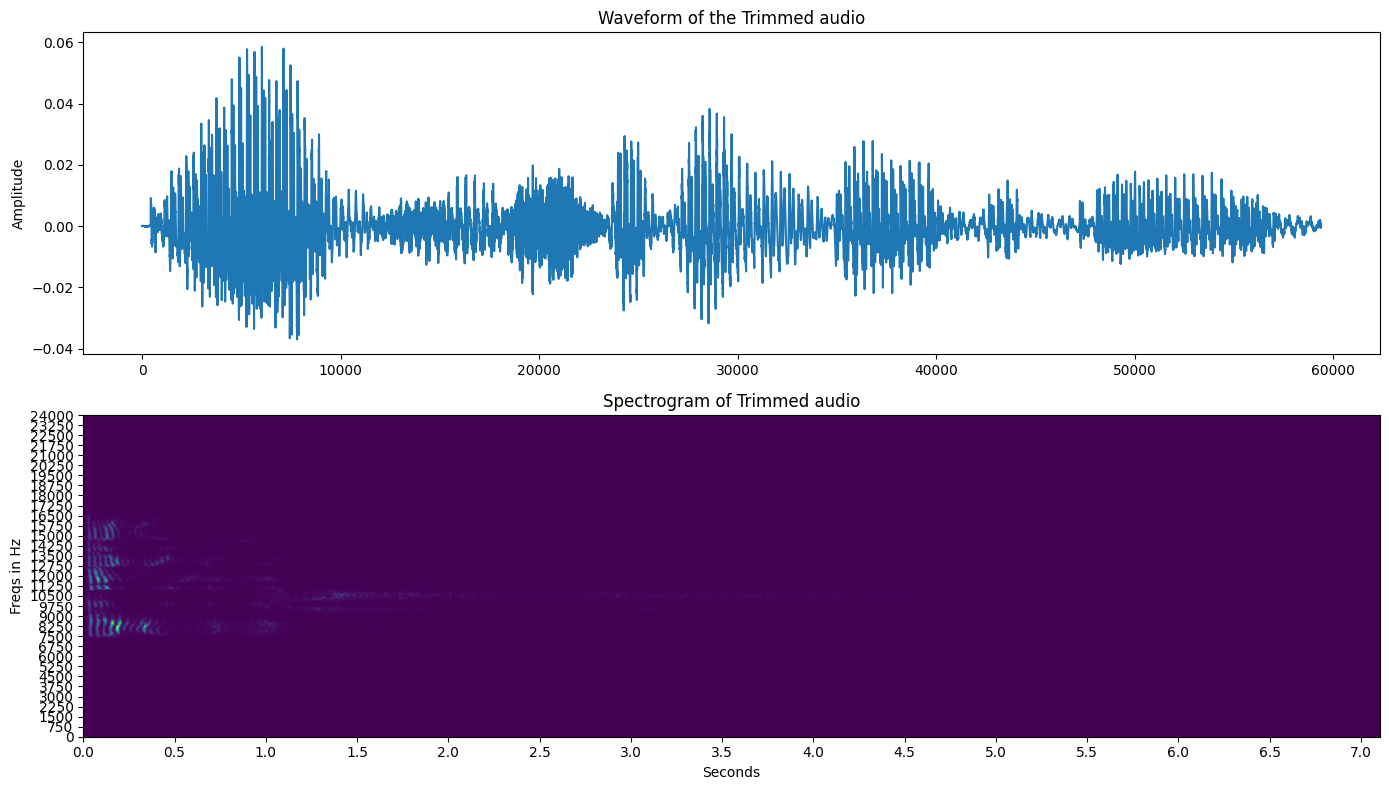

In [17]:
plt.figure(figsize=(14, 8))

# Plot waveform
plt.subplot(211)
plt.title('Waveform of the Trimmed audio')
plt.ylabel('Amplitude')
plt.plot(samples_trim)

# Plot spectrogram
plt.subplot(212)
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::32])
plt.xticks(np.arange(0.0, times.max(), 0.5))
plt.title('Spectrogram of Trimmed audio')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')

plt.tight_layout()
plt.show()

In [18]:
sample_weiner = scipy.signal.wiener(samples_trim)
len(sample_weiner)

59392

In [19]:
ipd.Audio(sample_weiner,rate=sample_rate)

In [20]:
Diff_noise = sample_weiner-samples_trim
ipd.Audio(Diff_noise,rate=sample_rate)

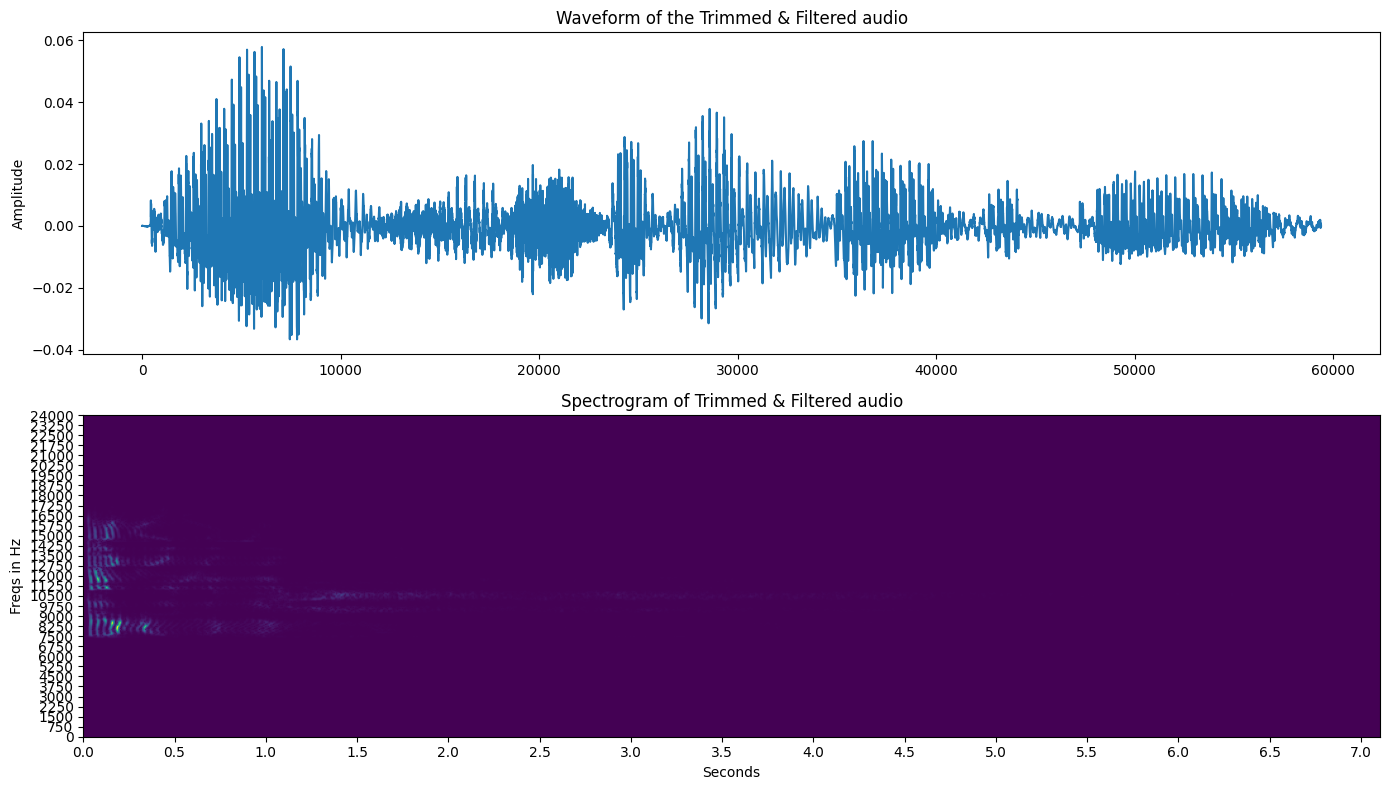

In [21]:
plt.figure(figsize=(14, 8))

# Plot waveform
plt.subplot(211)
plt.title('Waveform of the Trimmed & Filtered audio')
plt.ylabel('Amplitude')
plt.plot(sample_weiner)

# Plot spectrogram
plt.subplot(212)
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::32])
plt.xticks(np.arange(0.0, times.max(), 0.5))
plt.title('Spectrogram of Trimmed & Filtered audio')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')

plt.tight_layout()
plt.show()

### 6. Waveform of the noise in the audio

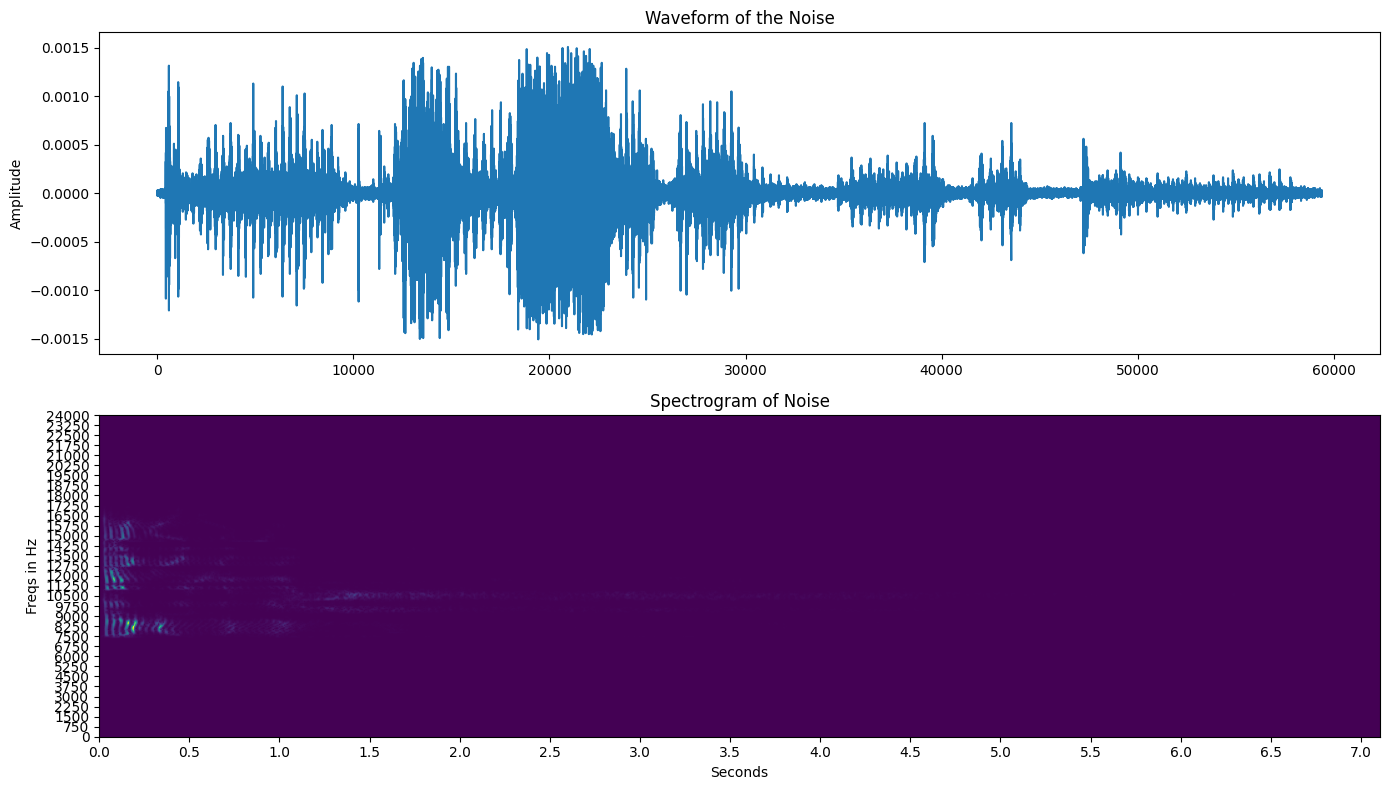

In [22]:
plt.figure(figsize=(14, 8))

# Plot waveform
plt.subplot(211)
plt.title('Waveform of the Noise')
plt.ylabel('Amplitude')
plt.plot(Diff_noise)

# Plot spectrogram
plt.subplot(212)
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::32])
plt.xticks(np.arange(0.0, times.max(), 0.5))
plt.title('Spectrogram of Noise')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')

plt.tight_layout()
plt.show()


### 7. Feature Extraction 

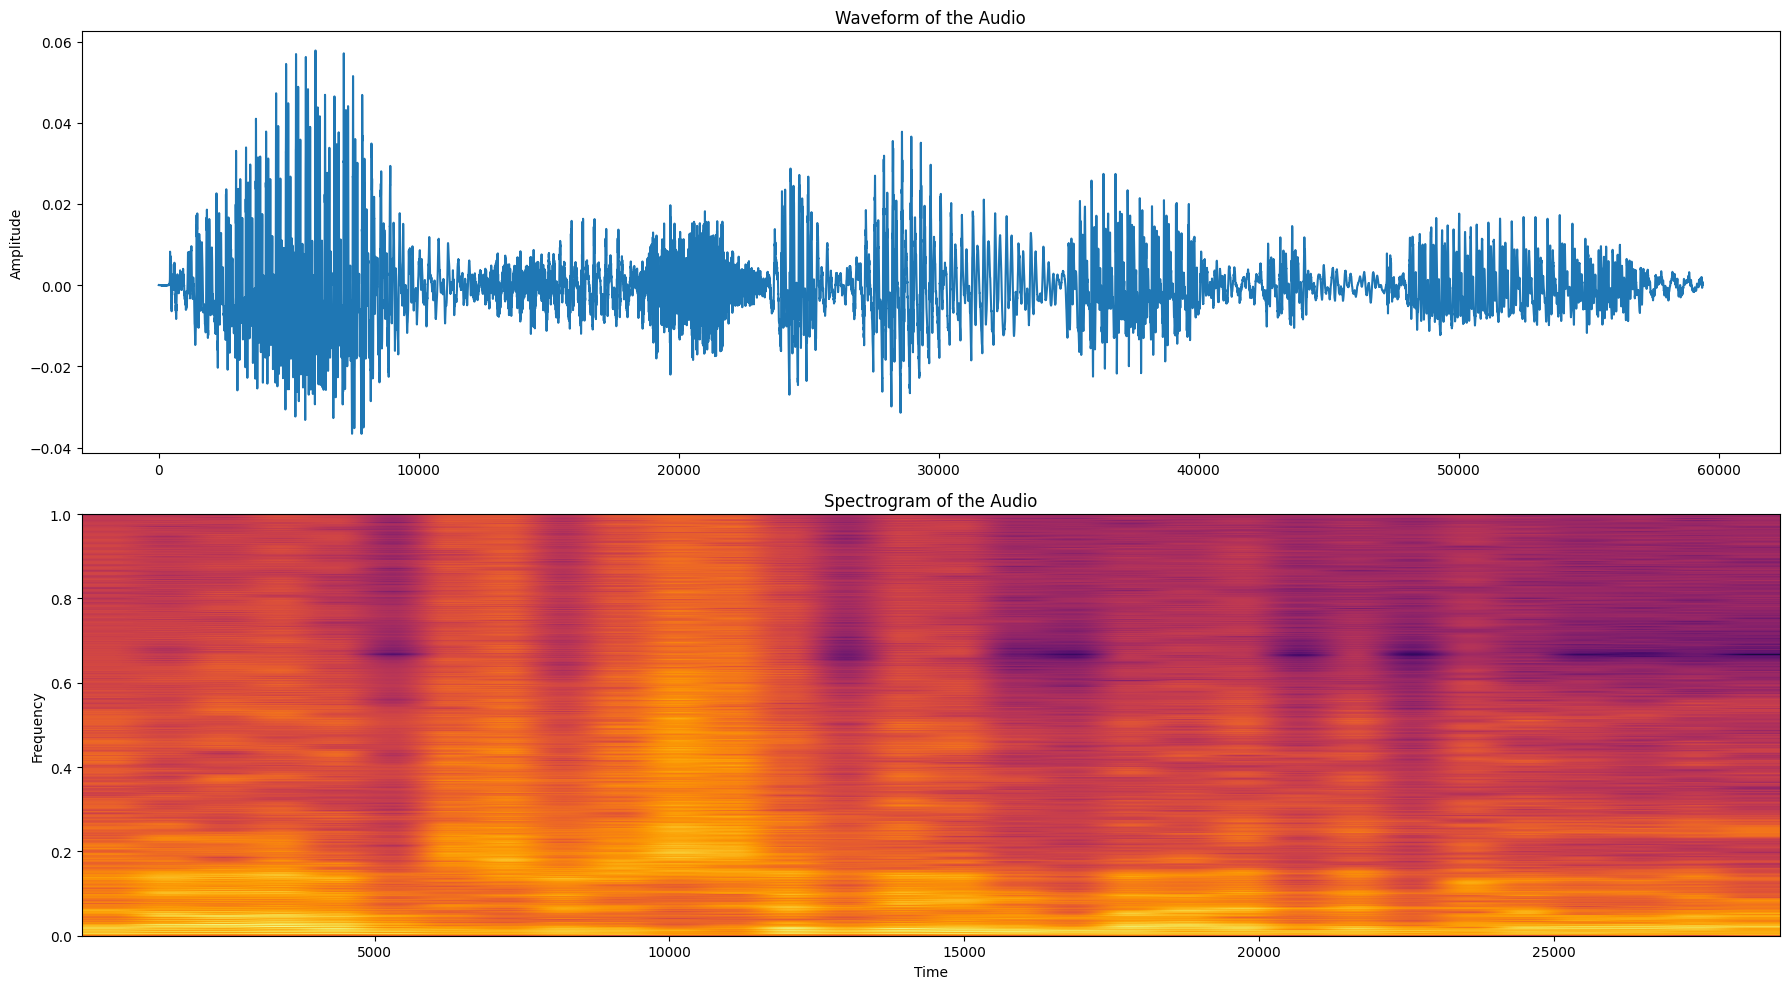

In [23]:
plt.figure(figsize=(18, 10))

# Plot waveform
plt.subplot(211)
plt.title('Waveform of the Audio')
plt.ylabel('Amplitude')
plt.plot(sample_weiner)

plt.subplots_adjust(hspace=.5)

# Plot spectrogram
plt.subplot(212)
plt.specgram(sample_weiner, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='inferno', sides='default', mode='default', scale='dB')
plt.title('Spectrogram of the Audio')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.tight_layout()
plt.show()


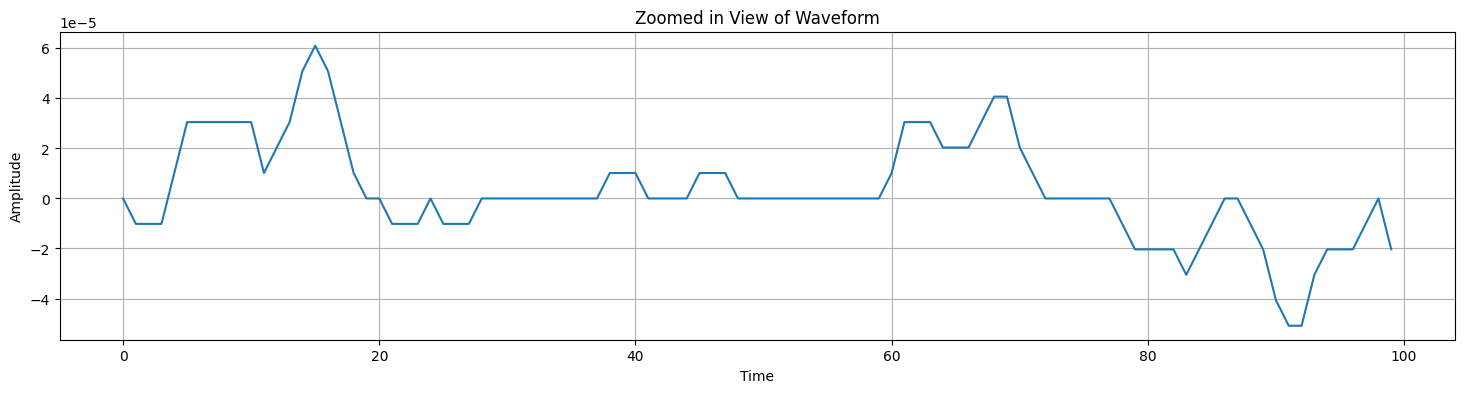

In [24]:
plt.figure(figsize=(18, 4))
plt.plot(sample_weiner[0:100])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Zoomed in View of Waveform")
plt.grid()


In [25]:
zero_crossings = librosa.zero_crossings(sample_weiner[0:100], pad=False)
print(sum(zero_crossings))


11


In [26]:
zero_crossings = librosa.zero_crossings(sample_weiner, pad=False)
print(sum(zero_crossings))

2486


In [27]:
spectral_centroids = librosa.feature.spectral_centroid(y=sample_weiner, sr=sample_rate)[0]
spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalizing the spectral centroid for visualization
sc = sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0)


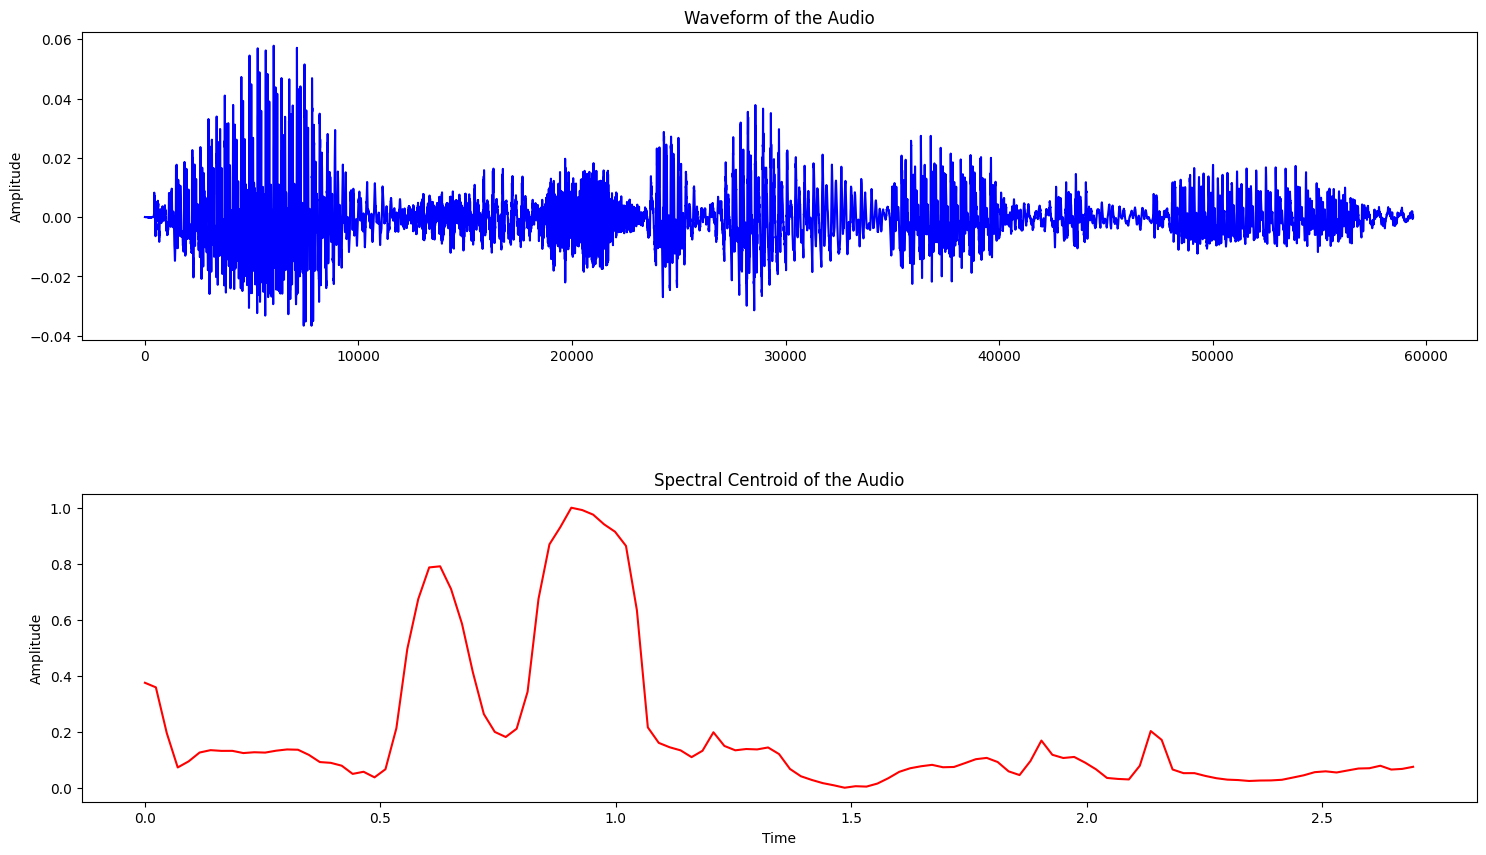

In [28]:
# Plotting Waveform and Spectral Centroid
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
plt.plot(sample_weiner, color='b')
fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectral Centroid of the Audio')
ax2.set_ylabel('Amplitude')
plt.plot(t, sc, color='r')
ax2.set_xlabel('Time')
fig.subplots_adjust(hspace=.5)

plt.show()


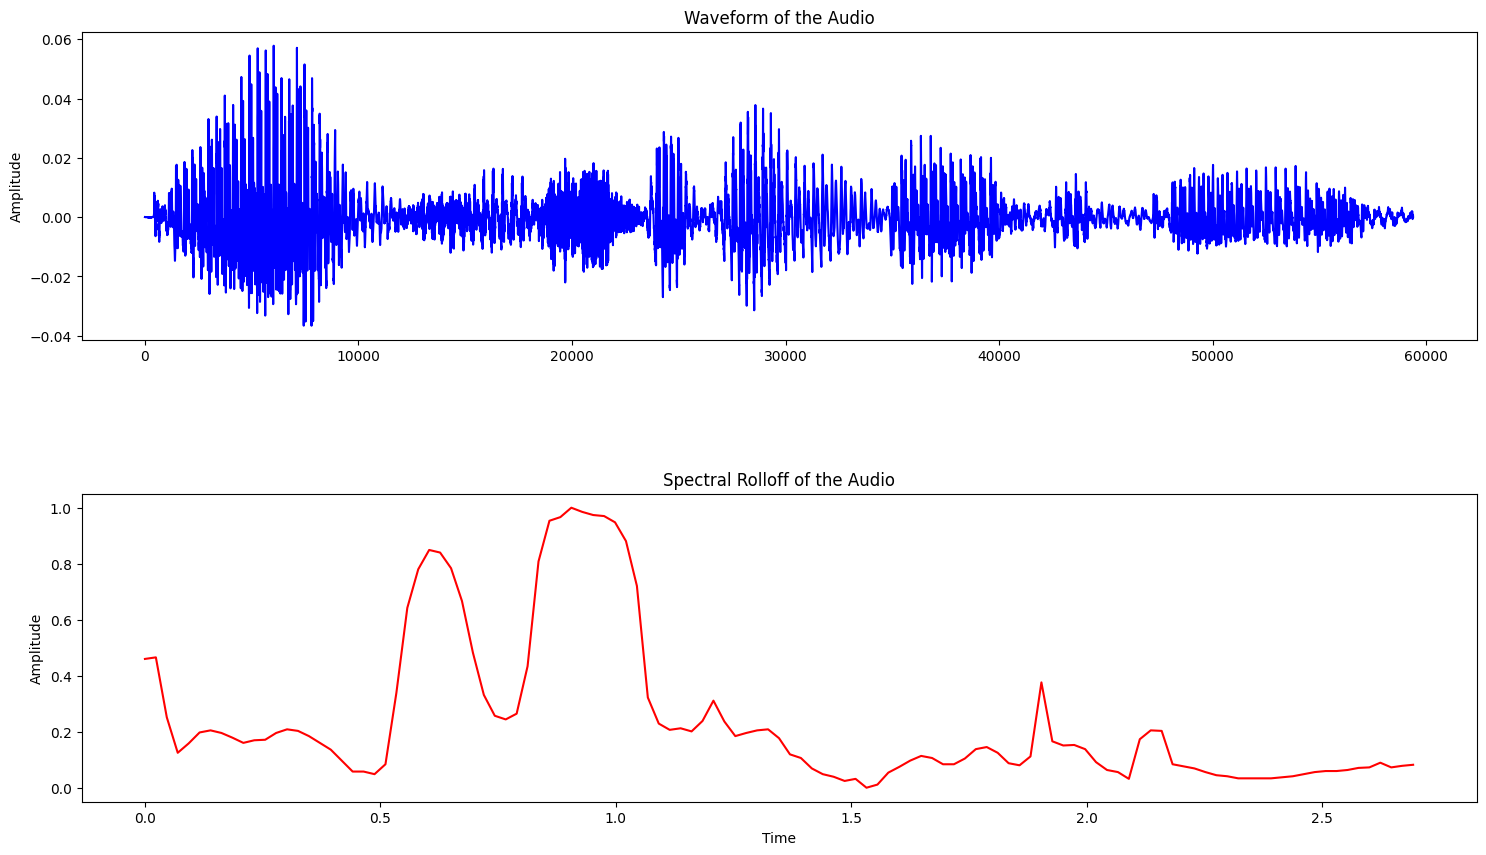

In [29]:
# Calculate Spectral Rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=sample_weiner, sr=sample_rate)[0]

# Computing the time variable for visualization
frames = range(len(spectral_rolloff))
t = librosa.frames_to_time(frames)

# Normalizing the spectral rolloff for visualization
sc = sklearn.preprocessing.minmax_scale(spectral_rolloff, axis=0)

# Plotting Waveform and Spectral Rolloff
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
plt.plot(sample_weiner, color='b')
fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectral Rolloff of the Audio')
ax2.set_ylabel('Amplitude')
plt.plot(t, sc, color='r')
ax2.set_xlabel('Time')
fig.subplots_adjust(hspace=.5)

plt.show()


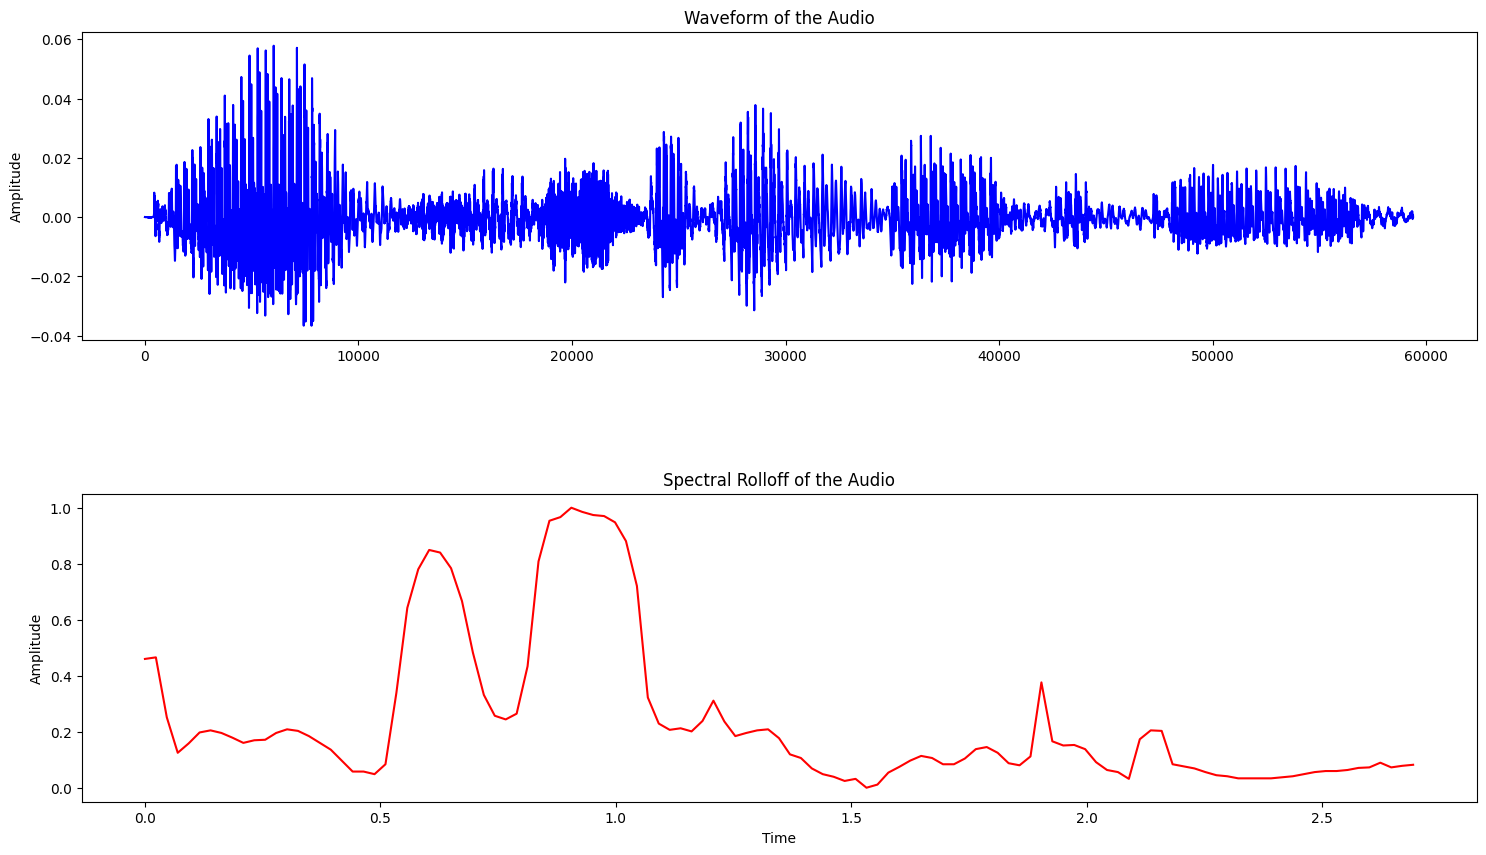

In [30]:
# Plotting Wave Form and Spectrogram
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
plt.plot(sample_weiner, color='b')
fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectral Rolloff of the Audio')
ax2.set_ylabel('Amplitude')
plt.plot(t, sc, color='r')
ax2.set_xlabel('Time')
fig.subplots_adjust(hspace=.5)

plt.show()

### 8. RMSE

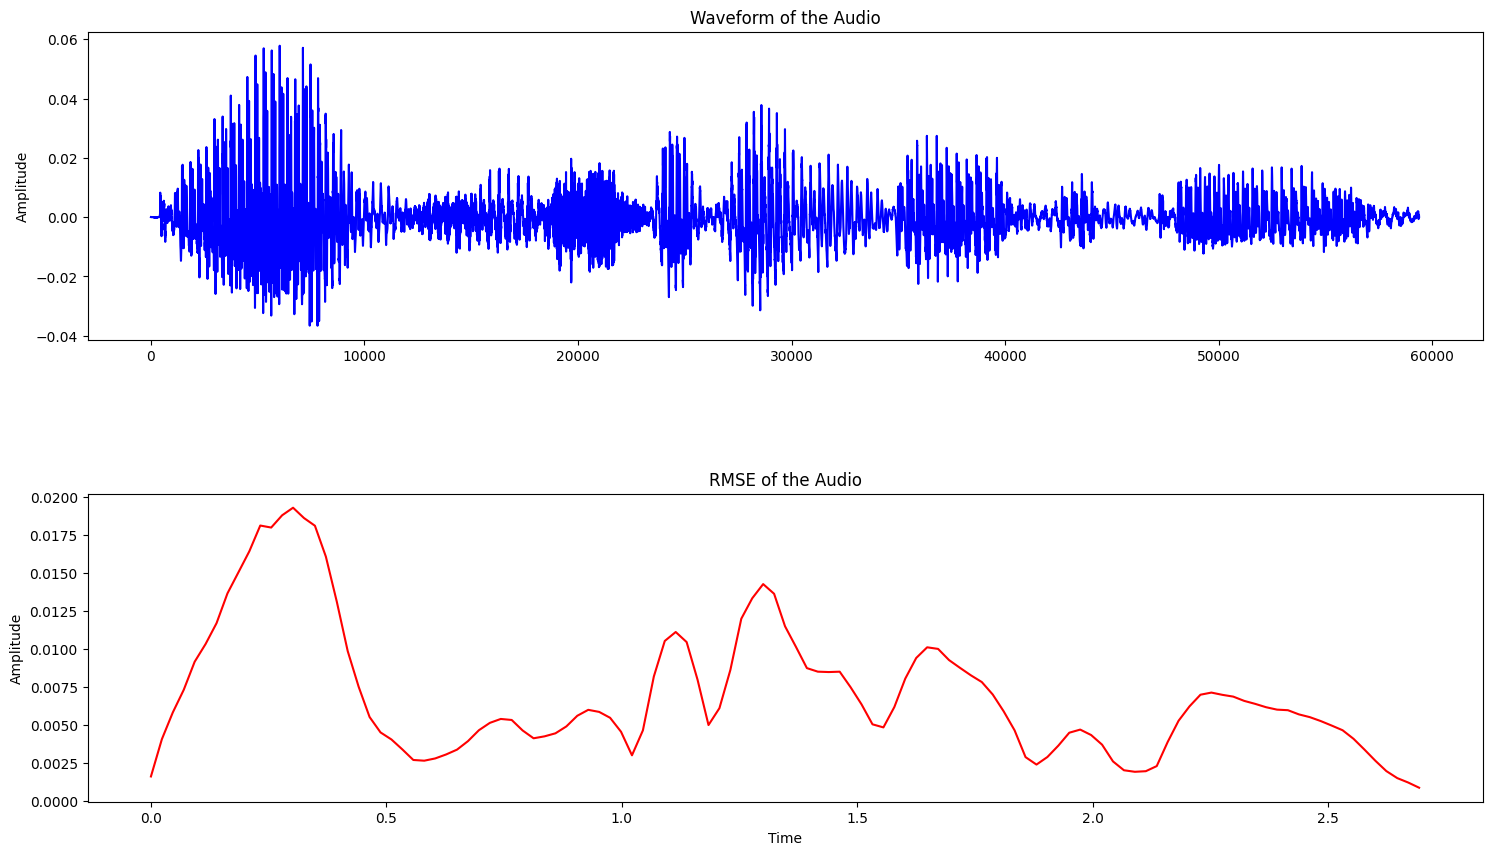

In [31]:
# Compute RMSE
rmse = librosa.feature.rms(y=sample_weiner)[0]

# Plotting Wave Form and RMSE
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
plt.plot(sample_weiner, color='b')
fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
ax2.set_title('RMSE of the Audio')
ax2.set_ylabel('Amplitude')
plt.plot(t, rmse, color='r')
ax2.set_xlabel('Time')
fig.subplots_adjust(hspace=.5)

plt.show()


### 9. Spectral Bandwidth ( Incomplete)

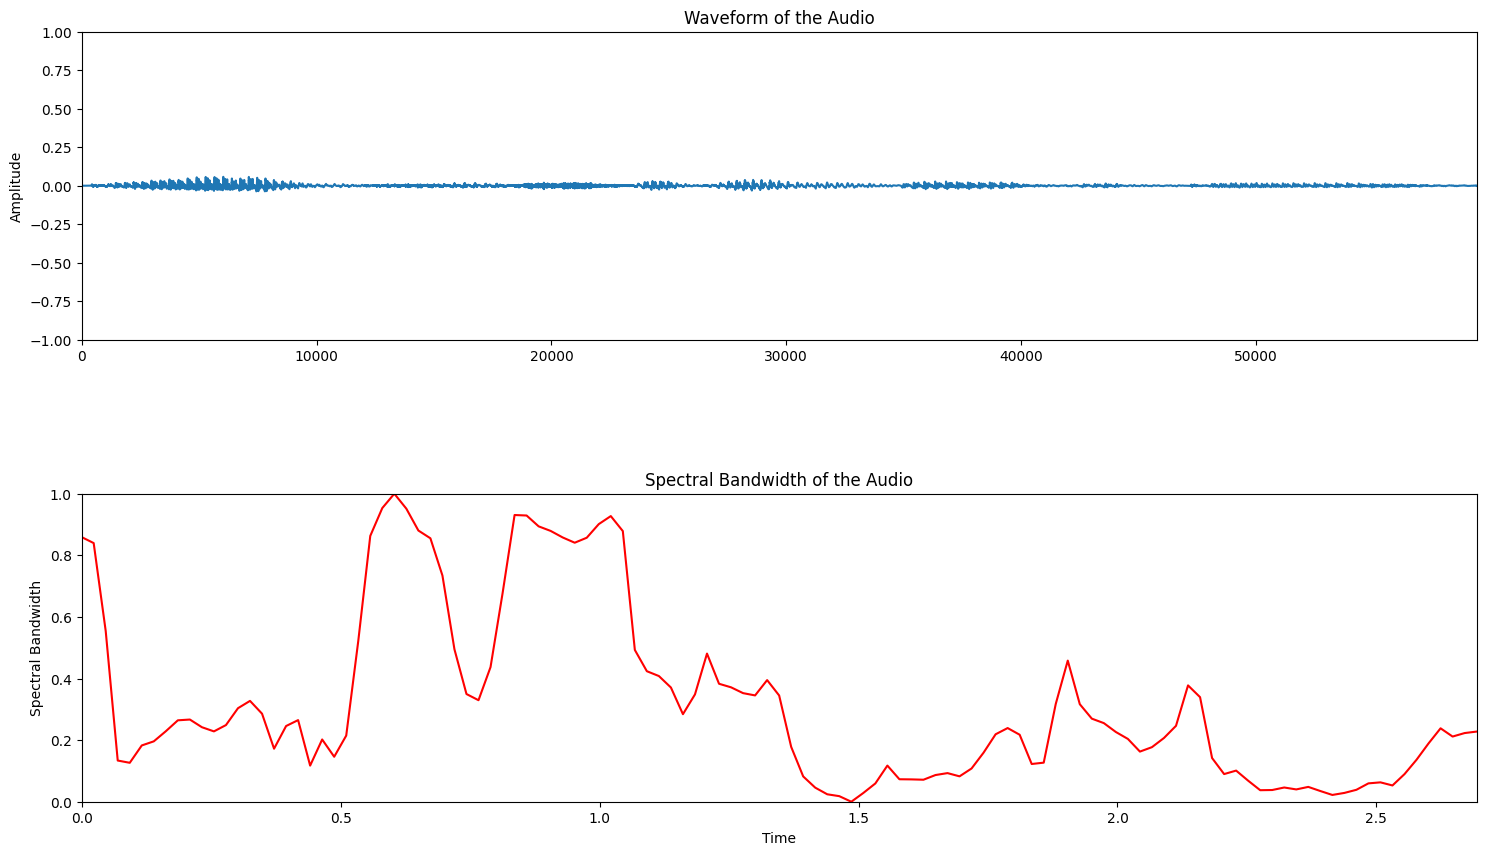

In [32]:
# Compute the spectral bandwidth
spec_bw = librosa.feature.spectral_bandwidth(y=sample_weiner, sr=sample_rate)[0]
spec_bw = sklearn.preprocessing.minmax_scale(spec_bw, axis=0)

# Plotting Waveform and Spectral Bandwidth
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

# Waveform
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
ax1.plot(sample_weiner)
ax1.set_xlim([0, len(sample_weiner)])
ax1.set_ylim([-1, 1])

# Spectral Bandwidth
ax2.set_title('Spectral Bandwidth of the Audio')
ax2.set_ylabel('Spectral Bandwidth')
ax2.plot(t, spec_bw, color='r')
ax2.set_xlim([0, t.max()])
ax2.set_ylim([0, spec_bw.max()])

plt.xlabel('Time')
plt.subplots_adjust(hspace=0.5)

plt.show()


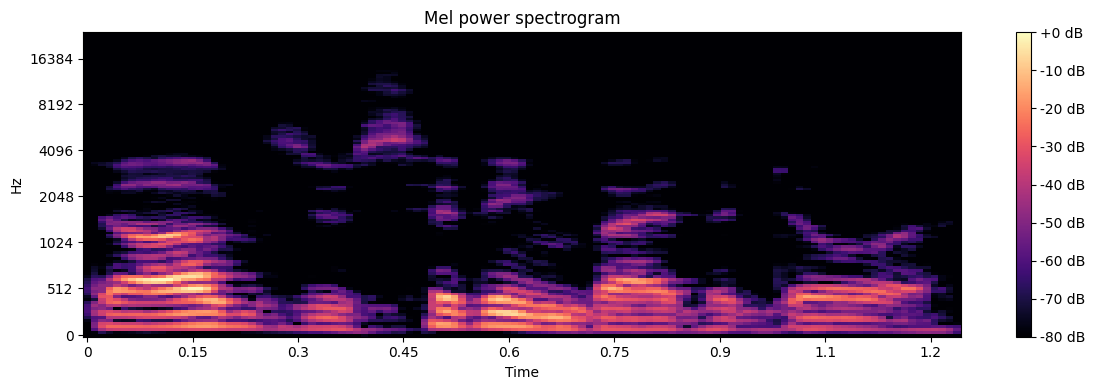

In [33]:
# Plotting Mel Power Spectrogram
S_sample = librosa.feature.melspectrogram(y=sample_weiner, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S_sample = librosa.amplitude_to_db(S_sample, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S_sample, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


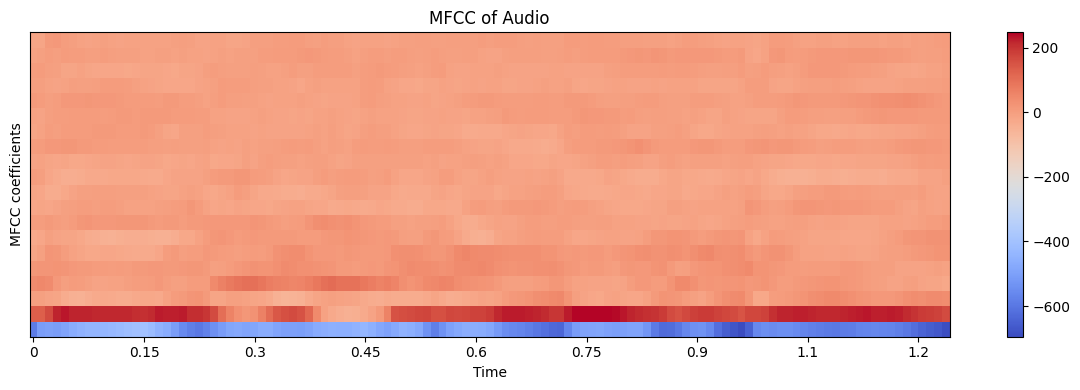

In [34]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=sample_weiner, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.ylabel('MFCC coefficients')
plt.xlabel('Time')
plt.title('MFCC of Audio')
plt.colorbar()
plt.tight_layout()
plt.show()


### 10. Delta MFCCS

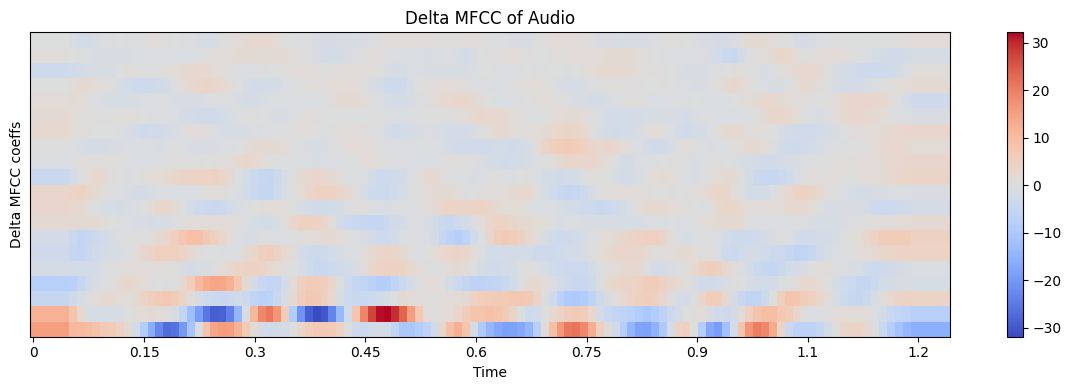

In [35]:
plt.figure(figsize=(12, 4))
delta_MFCCS =  librosa.feature.delta(mfccs,order=1)
librosa.display.specshow(delta_MFCCS, sr=sample_rate, x_axis='time')
plt.ylabel('Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('Delta MFCC of Audio')
plt.colorbar()
plt.tight_layout()

### 11. Delta Delta MFCCs

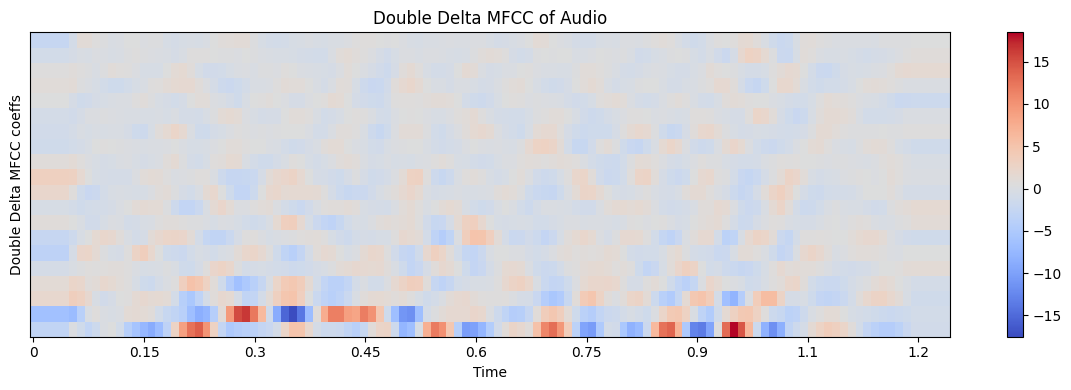

In [36]:
plt.figure(figsize=(12, 4))
d_delta_MFCCS =  librosa.feature.delta(mfccs,order=2)
librosa.display.specshow(d_delta_MFCCS, sr=sample_rate, x_axis='time')
plt.ylabel('Double Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('Double Delta MFCC of Audio')
plt.colorbar()
plt.tight_layout()

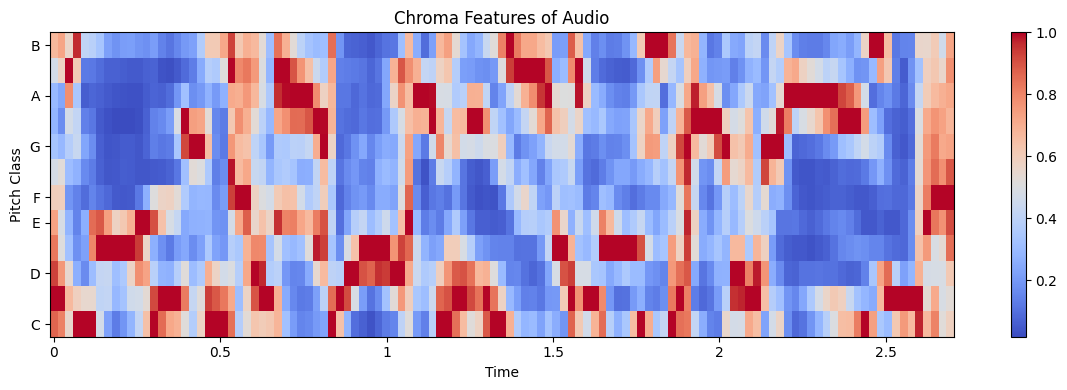

In [37]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(y=sample_weiner, sr=sample_rate, hop_length=hop_length)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.ylabel('Pitch Class')
plt.xlabel('Time')
plt.title('Chroma Features of Audio')
plt.colorbar()
plt.tight_layout()
plt.show()
